# Model V4

In [1]:
best_config ={'lstm_bidirectional': False,
              'batch_size': 64, 
              'lstm_hidden': 80, 
              'lstm_layers': 1, 
              'lstm_dropout': 0.2671316918441963, 
              'gat_hidden': 80, 
              'gat_dropout': 0.1993665828070434, 
              'gat_alpha': 0.14532408835157587, 
              'lstm_weight_decay': 0.003328205092369052, 
              'gat_weight_decay': 0.0002482672879648416, 
              'learning_rate': 0.003977102420179448, 
              'final_dropout': 0.2850697815808951, 
              'final_weight_decay': 0.00026907606292440243}

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

tickers = ['AAPL','AMZN','BA','COST','JNJ','NVDA','TMO','TSLA','VLO']
data_dir = "Data"

all_data = {}
min_length = float('inf')

for stock in tickers:
    path = os.path.join(data_dir, f"{stock}_with_sentiment_features_with_product.csv")
    df = pd.read_csv(path, parse_dates=['date'])

    # create log_return from daily_return
    df['log_return'] = np.log1p(df['daily_return'])

    features = [
        'close','volume','daily_return','log_return',
        'ann_return_1w','ann_return_2w','ann_return_1m',
        'rolling_vol_7d','macd_1w_1m',
        'sentiment_variance','product'
    ]
    cols = ['date'] + [f for f in features if f in df.columns]
    df = df[cols]

    # fill and drop
    df[['product','sentiment_variance']] = df[['product','sentiment_variance']].fillna(0)
    df = df.dropna().reset_index(drop=True)

    all_data[stock] = df
    min_length = min(min_length, len(df))

# align lengths
for stock in tickers:
    all_data[stock] = all_data[stock].tail(min_length).reset_index(drop=True)

# unified dates and train/test split
dates = all_data[tickers[0]]['date'].values
split_idx = int(len(dates) * 0.7)
train_dates = dates[:split_idx]
test_dates  = dates[split_idx:]

print(f"Train: {train_dates[0]} ~ {train_dates[-1]}")
print(f"Test:  {test_dates[0]} ~ {test_dates[-1]}")

Train: 2021-02-03T00:00:00.000000000 ~ 2024-02-09T00:00:00.000000000
Test:  2024-02-12T00:00:00.000000000 ~ 2025-05-30T00:00:00.000000000


In [4]:
scalers = {}
for stock in tickers:
    train_df = all_data[stock][all_data[stock]['date'].isin(train_dates)]
    scaler = StandardScaler()
    scaler.fit(train_df[features])
    scalers[stock] = scaler
print("Scaler finished.")


Scaler finished.


# Dynamic Grpah

In [5]:
import pandas as pd
import torch

# Load your dynamic graph file
graph_df = pd.read_csv("graph_final.csv")
graph_df['date'] = pd.to_datetime(graph_df['date'])

tickers = ['AAPL', 'AMZN', 'BA', 'COST', 'JNJ', 'NVDA', 'TMO', 'TSLA', 'VLO']
edge_columns = graph_df.columns[1:]
stock_pairs = [col.split('&') for col in edge_columns]

# Build a dictionary mapping date → (edge_index, edge_attr)
date_to_graph = {}

for _, row in graph_df.iterrows():
    edge_index = []
    edge_attr = []
    for (stock1, stock2), col in zip(stock_pairs, edge_columns):
        if stock1 in tickers and stock2 in tickers:
            i = tickers.index(stock1)
            j = tickers.index(stock2)
            weight = float(row[col])
            if weight != 0:
                edge_index.append([i, j])
                edge_attr.append(weight)

    if edge_index:
        ei_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        ea_tensor = torch.tensor(edge_attr, dtype=torch.float32)
        date_str = row['date'].strftime('%Y-%m-%d')
        date_to_graph[date_str] = (ei_tensor, ea_tensor)

# Pick the date you're interested in
target_date = '2021-02-02'


import numpy as np
adj_matrix = np.zeros((len(tickers), len(tickers)))

# Define LSTM and GAT

In [6]:
# LSTM
class StockLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, bidirectional=bidirectional)
    def forward(self, x):
        output, (h_n, _) = self.lstm(x)
        return output[:, -1, :]

# WeightedGATConv
class WeightedGATConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0, alpha=0.2):
        super().__init__()
        self.lin = nn.Linear(in_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.leaky_relu = nn.LeakyReLU(alpha)
    def forward(self, x, edge_index, edge_weight):
        x = self.lin(x)
        x = self.dropout(x)
        num_nodes = x.size(0)
        agg = torch.zeros_like(x)
        for idx in range(edge_index.size(1)):
            src = edge_index[0, idx]
            tgt = edge_index[1, idx]
            agg[tgt] += edge_weight[idx] * x[src]
        return self.leaky_relu(agg + x)

class GATEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0, alpha=0.2):
        super().__init__()
        self.gat1 = WeightedGATConv(in_dim, hidden_dim, dropout, alpha)
        self.gat2 = WeightedGATConv(hidden_dim, out_dim, dropout, alpha)
    def forward(self, x, edge_index, edge_weight):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.gat2(x, edge_index, edge_weight)
        return x


class PortfolioNet(nn.Module):
    def __init__(self, config, input_dim, tickers):
        super().__init__()
        self.lstm_encoder = StockLSTMEncoder(
            input_dim=input_dim,
            hidden_dim=config['lstm_hidden'],
            num_layers=config['lstm_layers'],
            dropout=config['lstm_dropout'],
            bidirectional=config['lstm_bidirectional']
        )
        gat_input_dim = config['lstm_hidden'] * (2 if config['lstm_bidirectional'] else 1)
        self.gat_encoder = GATEncoder(
            in_dim=gat_input_dim,
            hidden_dim=config['gat_hidden'],
            out_dim=config['gat_hidden'],
            dropout=config['gat_dropout'],
            alpha=config['gat_alpha']
        )
        self.final_dropout = nn.Dropout(config.get('final_dropout', 0.2))
        self.final_layer = nn.Linear(config['gat_hidden'], 1)
        self.tickers = tickers

    def forward(self, seq_features, edge_index, edge_attr):
        # seq_features: [N_stocks, seq_len, feature_dim]
        x = self.lstm_encoder(seq_features)
        x = self.gat_encoder(x, edge_index, edge_attr)
        x = self.final_dropout(x)
        raw_scores = self.final_layer(x).squeeze(-1)
        weights = torch.tanh(raw_scores)
        norm_weights = weights / (weights.sum() + 1e-8)
        return norm_weights



In [7]:
def sharpe_ratio_loss(weights, returns, cov_matrix):
    expected_return = torch.dot(weights, returns)
    portfolio_var = weights.unsqueeze(0) @ cov_matrix @ weights.unsqueeze(1)
    portfolio_std = torch.sqrt(portfolio_var + 1e-8).squeeze()
    sharpe = expected_return / (portfolio_std + 1e-8)
    return -sharpe

# Training Loop

In [8]:
epochs = 40
batch_size = best_config['batch_size']
seq_len = 30




model = PortfolioNet(best_config, input_dim=len(features), tickers=tickers).to(device)
optimizer = torch.optim.Adam(
    [
        {'params': model.lstm_encoder.parameters(), 'weight_decay': best_config['lstm_weight_decay']},
        {'params': model.gat_encoder.parameters(), 'weight_decay': best_config['gat_weight_decay']},
        {'params': model.final_layer.parameters(), 'weight_decay': best_config.get('final_weight_decay', 0.0)}
    ],
    lr=best_config['learning_rate']
)

date2idx = {d: i for i, d in enumerate(dates)}
train_indices = [date2idx[d] for d in train_dates]

edge_index = None
edge_attr = None


for epoch in range(epochs):
    total_loss = 0.0
    train_points = train_indices[seq_len:-1]
    random.shuffle(train_points)
    num_batches = (len(train_points) + batch_size - 1) // batch_size

    progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx in progress_bar:
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(train_points))
        batch_indices = train_points[start_idx:end_idx]
        stock_embeddings_batch = []
        future_returns_batch = []
        past_returns_batch = []

        for t in batch_indices:
            seq_batch = []
            future_returns = []
            skip_flag = False
            for stock in tickers:
                df = all_data[stock]
                if t - seq_len < 0 or t + 1 >= len(df):
                    skip_flag = True
                    break
                seq = df[features].iloc[t-seq_len:t]
                seq = scalers[stock].transform(seq)
                seq_batch.append(seq)
                future_returns.append(df['log_return'].iloc[t+1])
            if skip_flag:
                continue
            stock_embeddings_batch.append(torch.tensor(seq_batch, dtype=torch.float32, device=device))
            future_returns_batch.append(torch.tensor(future_returns, dtype=torch.float32, device=device))
            window = min(20, t)
            past_returns = np.array([
                all_data[stock]['log_return'].iloc[t-window:t].values
                for stock in tickers
            ])
            past_returns_batch.append(torch.tensor(np.cov(past_returns) + 1e-6*np.eye(len(tickers)), dtype=torch.float32, device=device))

        if len(stock_embeddings_batch) == 0:
            continue

        x_t_batch = torch.stack(stock_embeddings_batch).to(device)
        future_returns_tensor = torch.stack(future_returns_batch).to(device)
        cov_matrices_tensor = torch.stack(past_returns_batch).to(device)

        batch_loss = 0.0
        for i in range(x_t_batch.shape[0]):
            t_idx = batch_indices[i]

            # update edge_index & edge_attr every 7 trading days or if uninitialized
            if (t_idx % 5 == 0) or (edge_index is None or edge_attr is None):
                current_date = dates[t_idx]
                graph_key = pd.to_datetime(current_date).strftime('%Y-%m-%d')
                if graph_key in date_to_graph: edge_index, edge_attr = date_to_graph[graph_key]
                else:
                    print(f"[Warning] Graph not found for {graph_key}, using full fallback.")
                    edge_list = [[m, n] for m in range(len(tickers)) for n in range(len(tickers)) if m != n]
                    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                    edge_attr = torch.ones(edge_index.shape[1], dtype=torch.float32)



            norm_weights = model(
                x_t_batch[i],
                edge_index.to(device),
                edge_attr.to(device)
            )

            loss = sharpe_ratio_loss(norm_weights, future_returns_tensor[i], cov_matrices_tensor[i])
            batch_loss += loss

        avg_batch_loss = batch_loss / x_t_batch.shape[0]
        optimizer.zero_grad()
        avg_batch_loss.backward()
        optimizer.step()
        total_loss += avg_batch_loss.item()
        progress_bar.set_postfix(loss=avg_batch_loss.item())

    avg_epoch_loss = total_loss / num_batches
    print(f"Epoch {epoch+1} | Avg Loss: {avg_epoch_loss:.6f}")

print("Training Finished")


Epoch 1/40:   0%|          | 0/12 [00:00<?, ?it/s]/var/folders/5r/qzktzj2d0sqgdb3w7g4q41lc0000gn/T/ipykernel_51916/1466925226.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  stock_embeddings_batch.append(torch.tensor(seq_batch, dtype=torch.float32, device=device))
Epoch 1/40: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s, loss=-0.0548]


Epoch 1 | Avg Loss: -0.042023


Epoch 2/40: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s, loss=0.031] 


Epoch 2 | Avg Loss: -0.037833


Epoch 3/40: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s, loss=0.0221]


Epoch 3 | Avg Loss: -0.041065


Epoch 4/40: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, loss=0.137] 


Epoch 4 | Avg Loss: -0.040951


Epoch 5/40: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s, loss=0.039]  


Epoch 5 | Avg Loss: -0.032305


Epoch 6/40: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, loss=-0.00729]


Epoch 6 | Avg Loss: -0.036742


Epoch 7/40: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s, loss=0.0269]


Epoch 7 | Avg Loss: -0.034635


Epoch 8/40: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s, loss=-0.175] 


Epoch 8 | Avg Loss: -0.045156


Epoch 9/40: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s, loss=0.0594]


Epoch 9 | Avg Loss: -0.033499


Epoch 10/40: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s, loss=-0.03] 


Epoch 10 | Avg Loss: -0.037088


Epoch 11/40: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s, loss=-0.142] 


Epoch 11 | Avg Loss: -0.043136


Epoch 12/40: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s, loss=-0.199] 


Epoch 12 | Avg Loss: -0.046262


Epoch 13/40: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s, loss=0.0304] 


Epoch 13 | Avg Loss: -0.035066


Epoch 14/40: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s, loss=0.0889]


Epoch 14 | Avg Loss: -0.034634


Epoch 15/40: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s, loss=0.0333] 


Epoch 15 | Avg Loss: -0.033860


Epoch 16/40: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s, loss=-0.0238]


Epoch 16 | Avg Loss: -0.037002


Epoch 17/40: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s, loss=-0.000273]


Epoch 17 | Avg Loss: -0.035557


Epoch 18/40: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s, loss=-0.317] 


Epoch 18 | Avg Loss: -0.051822


Epoch 19/40: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s, loss=-0.042]  


Epoch 19 | Avg Loss: -0.037563


Epoch 20/40: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s, loss=-0.0197]


Epoch 20 | Avg Loss: -0.036824


Epoch 21/40: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s, loss=-0.0999]


Epoch 21 | Avg Loss: -0.041092


Epoch 22/40: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s, loss=-0.232] 


Epoch 22 | Avg Loss: -0.047044


Epoch 23/40: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s, loss=0.198] 


Epoch 23 | Avg Loss: -0.025063


Epoch 24/40: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, loss=-0.151] 


Epoch 24 | Avg Loss: -0.044985


Epoch 25/40: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s, loss=-0.35] 


Epoch 25 | Avg Loss: -0.056058


Epoch 26/40: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s, loss=0.0626] 


Epoch 26 | Avg Loss: -0.035525


Epoch 27/40: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s, loss=-0.0461]


Epoch 27 | Avg Loss: -0.039028


Epoch 28/40: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s, loss=0.138]  


Epoch 28 | Avg Loss: -0.030769


Epoch 29/40: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, loss=-0.00842]


Epoch 29 | Avg Loss: -0.039493


Epoch 30/40: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s, loss=0.075] 


Epoch 30 | Avg Loss: -0.031540


Epoch 31/40: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, loss=0.253]   


Epoch 31 | Avg Loss: -0.027017


Epoch 32/40: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s, loss=-0.052]


Epoch 32 | Avg Loss: -0.044617


Epoch 33/40: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s, loss=-0.426]


Epoch 33 | Avg Loss: -0.066541


Epoch 34/40: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s, loss=-0.0451]


Epoch 34 | Avg Loss: -0.052026


Epoch 35/40: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, loss=-0.0498]


Epoch 35 | Avg Loss: -0.053230


Epoch 36/40: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s, loss=-0.358] 


Epoch 36 | Avg Loss: -0.049253


Epoch 37/40: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s, loss=-0.0875] 


Epoch 37 | Avg Loss: -0.037263


Epoch 38/40: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s, loss=-0.197] 


Epoch 38 | Avg Loss: -0.054309


Epoch 39/40: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, loss=0.127]  


Epoch 39 | Avg Loss: -0.029295


Epoch 40/40: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s, loss=0.245]  

Epoch 40 | Avg Loss: -0.027200
Training Finished


In [12]:
# Save
torch.save(model.state_dict(), "best_portfolio_model_v4.pth")

# Load
model.load_state_dict(torch.load("best_portfolio_model_v4.pth"))
model.eval()
print("Model is saved and reload.")


Model is saved and reload.


# Start Testing

In [23]:
test_indices = [date2idx[d] for d in test_dates]
test_points = test_indices[seq_len:-1]

weights_all_days = []
test_dates_list = []

num_batches = len(test_points) // batch_size
if len(test_points) % batch_size != 0:
    num_batches += 1

for batch_idx in tqdm(range(num_batches), desc="Predicting (test set)"):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(test_points))
    batch_indices = test_points[start_idx:end_idx]

    stock_embeddings_batch = []

    for t in batch_indices:
        seq_batch = []
        skip_flag = False
        for stock in tickers:
            df = all_data[stock]
            if t - seq_len < 0 or t + 1 >= len(df):
                skip_flag = True
                break
            seq = df[features].iloc[t-seq_len:t]
            seq = scalers[stock].transform(seq)
            seq_batch.append(seq)
        if skip_flag: continue
        stock_embeddings_batch.append(torch.tensor(seq_batch, dtype=torch.float32, device=device))
        test_dates_list.append(dates[t])


    if len(stock_embeddings_batch) == 0: continue
    x_t_batch = torch.stack(stock_embeddings_batch).to(device)
    for i in range(x_t_batch.shape[0]):
        x_t = x_t_batch[i]
        with torch.no_grad():
            norm_weights = model(
                x_t,
                edge_index.to(device),
                edge_attr.to(device)
            )
        weights_all_days.append(norm_weights.cpu().numpy())

weights_df = pd.DataFrame(weights_all_days, columns=tickers)
weights_df['date'] = test_dates_list
weights_df.to_csv("Result/predicted_weights_v4.csv", index=False)
print("File path: Result/predicted_weights_v4.csv")


Predicting (test set): 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

File path: Result/predicted_weights_v4.csv


In [14]:
# Build DataFrame
test_price_data = pd.DataFrame({'date': test_dates_list})
for stock in tickers:
    prices = []
    for d in test_dates_list:
        idx = date2idx[d]
        prices.append(all_data[stock].iloc[idx]['close'])
    test_price_data[stock] = prices

# Calculate Daily Return
returns = test_price_data[tickers].pct_change().dropna().reset_index(drop=True)
weights = weights_df[tickers].iloc[:-1].reset_index(drop=True)

# Portfolio returns and equal-weight return
portfolio_returns = (returns.values * weights.values).sum(axis=1)
equal_weights = np.ones(len(tickers)) / len(tickers)
equal_returns = (returns.values * equal_weights).sum(axis=1)

# Cumulative return
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_equal = (1 + equal_returns).cumprod()

import numpy as np
cumulative_return = cumulative_portfolio[-1] - 1
mean_ret = np.mean(portfolio_returns)
std_ret  = np.std(portfolio_returns, ddof=1)
sharpe_ratio = mean_ret / std_ret * np.sqrt(252)

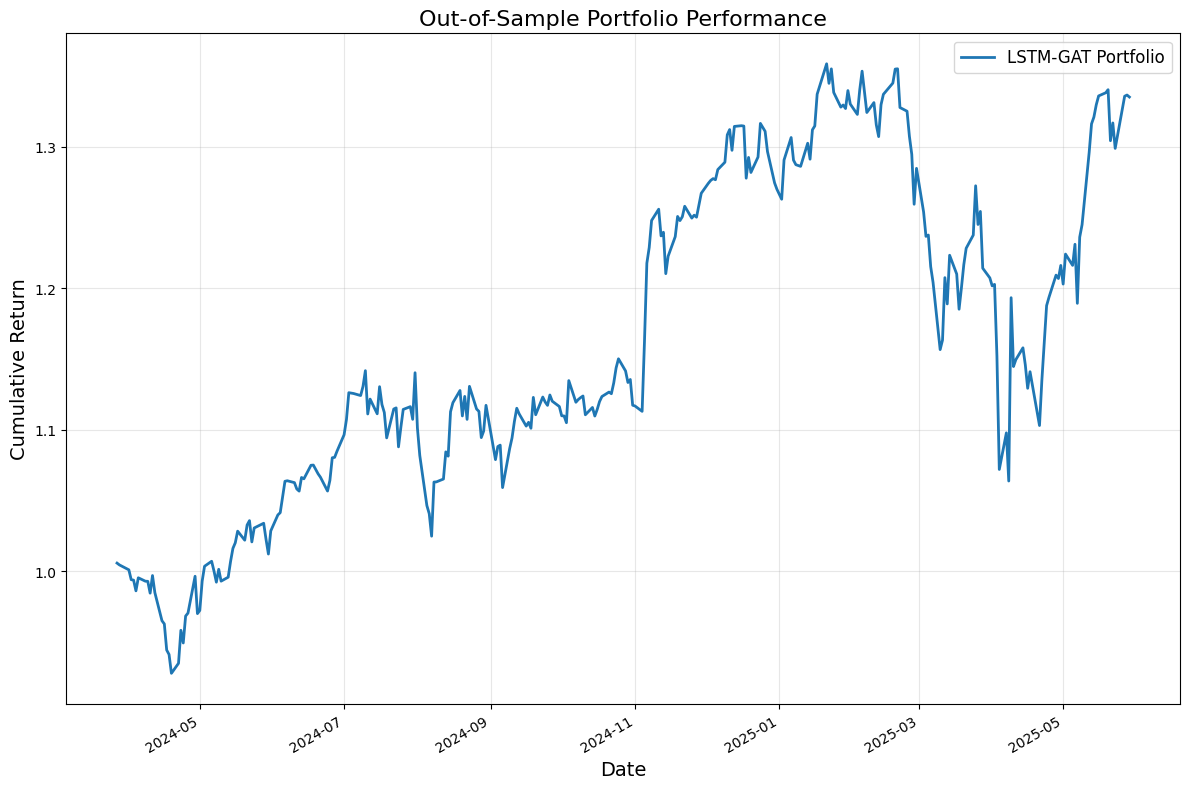

In [15]:
# Visualize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plot_dates = pd.to_datetime(test_price_data['date'].iloc[1:])

plt.figure(figsize=(12, 8))
plt.plot(plot_dates, cumulative_portfolio, label='LSTM-GAT Portfolio', linewidth=2)
plt.title('Out-of-Sample Portfolio Performance', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig('out_of_sample_performance.png', dpi=300)
plt.show()

In [16]:
# Load DataFrame
result_df = pd.DataFrame({
    'date': plot_dates,
    'lstm_gat_return': portfolio_returns, 
    'lstm_gat_cum_return': cumulative_portfolio,
    'equal_weight_return': equal_returns,
    'equal_weight_cum_return': cumulative_equal
})

result_df.to_csv('Result/portfolio_returns_v4.csv', index=False)
print("File path: Result/portfolio_returns_v4.csv")

File path: Result/portfolio_returns_v4.csv


In [17]:
capm_df = (
    pd.read_csv("Result/capm_cumulative_returns.csv",
                parse_dates=["date"])
      .rename(columns={"cumulative_return": "capm_cumulative"})
)

capm_df = capm_df[capm_df["date"].between(
    test_price_data['date'].iloc[1],
    test_price_data['date'].iloc[-1])]


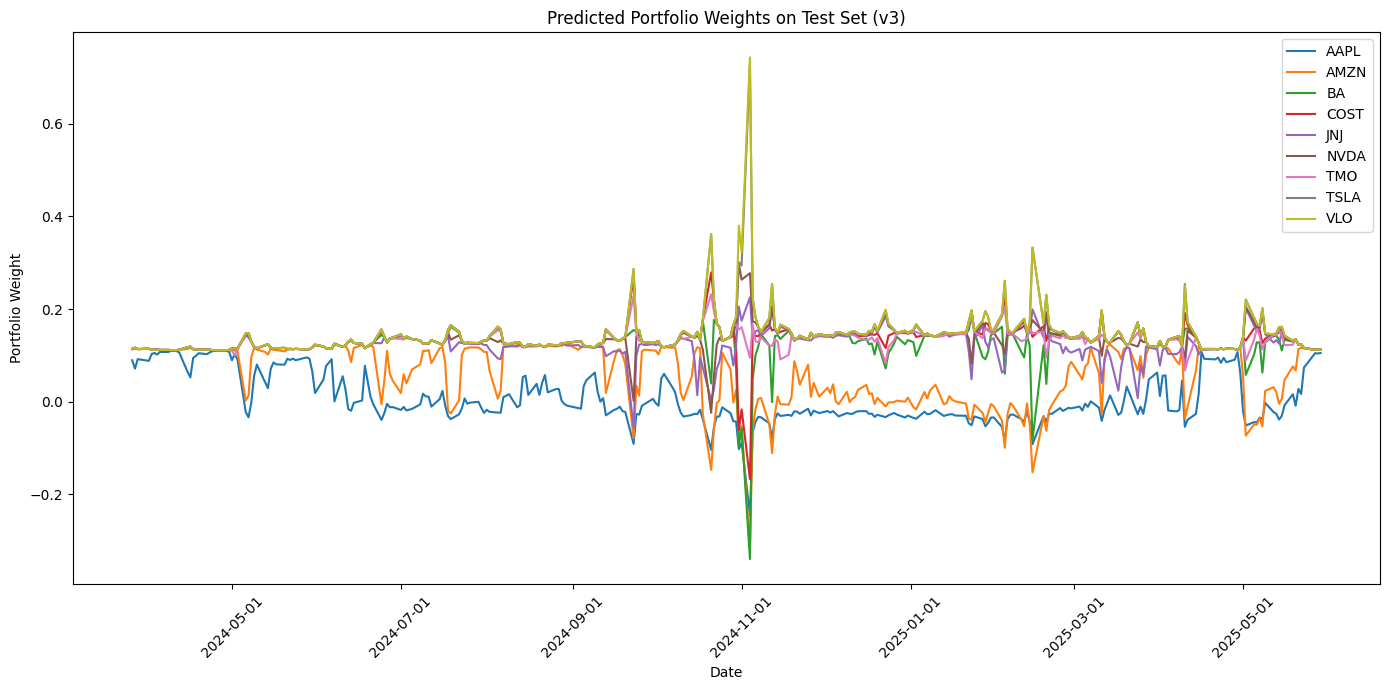

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))
weights_df['date'] = pd.to_datetime(weights_df['date'])

# Plot portfolio weights
for stock in tickers:
    plt.plot(weights_df['date'], weights_df[stock], label=stock)


plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Portfolio Weight')
plt.title('Predicted Portfolio Weights on Test Set (v3)')
plt.legend()

plt.tight_layout()
plt.show()

# CAPM-MVO Result

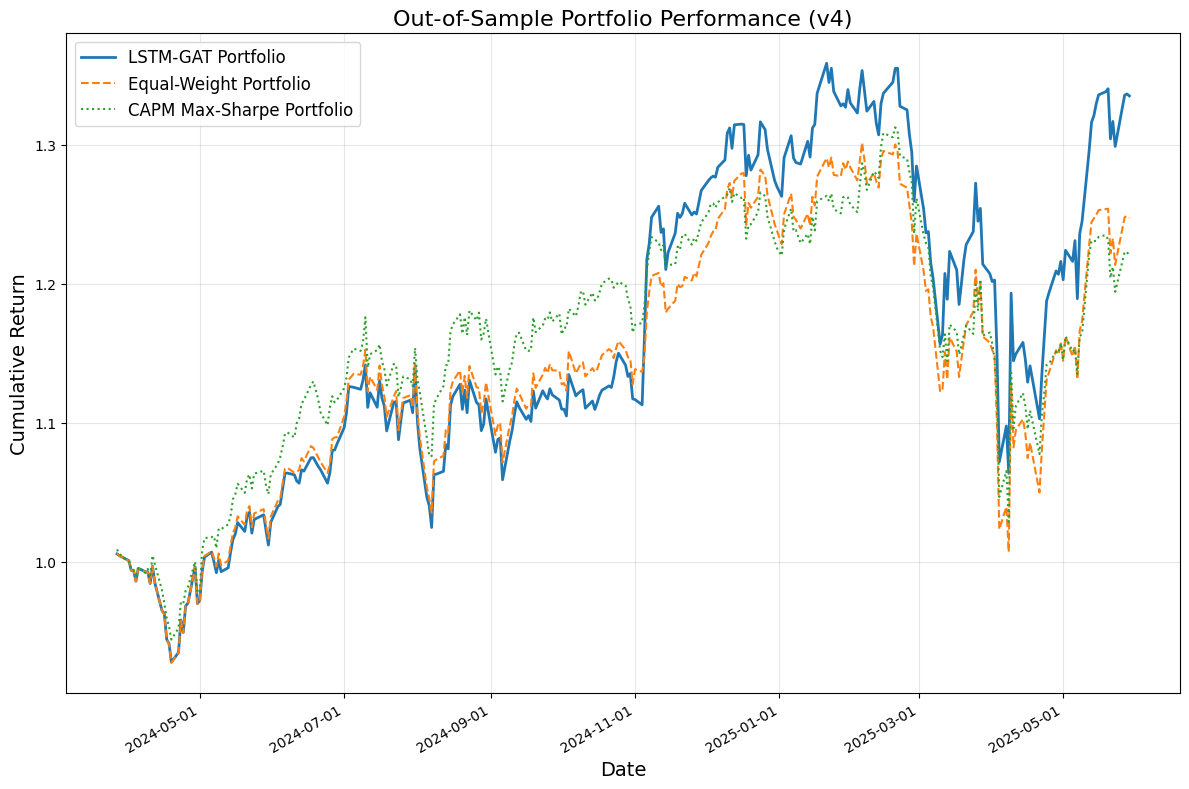

In [19]:
plt.figure(figsize=(12, 8))

plt.plot(plot_dates, cumulative_portfolio,
         label='LSTM-GAT Portfolio', linewidth=2)
plt.plot(plot_dates, cumulative_equal,
         label='Equal-Weight Portfolio', linestyle='--')


plt.plot(capm_df['date'], capm_df['capm_cumulative'],
         label='CAPM Max-Sharpe Portfolio', linestyle=':')

plt.title('Out-of-Sample Portfolio Performance (v4)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.savefig('Result/V4_out_of_sample_performance_with_capm.png', dpi=300)
plt.show()

# Evaluation

In [20]:
import numpy as np
import pandas as pd

def calculate_metrics(returns, var_conf_level=0.95):
    returns = pd.Series(returns)
    cumulative = (1 + returns).cumprod()
    total_return = cumulative.iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    
    # Historical Value at Risk (e.g., 5% worst return)
    var_percentile = 100 * (1 - var_conf_level)
    value_at_risk = -np.percentile(returns, var_percentile)

    return total_return, annualized_return, volatility, sharpe_ratio, max_drawdown, value_at_risk

port_metrics = calculate_metrics(portfolio_returns)
equal_metrics = calculate_metrics(equal_returns)
capm_df = pd.read_csv('Result/capm_daily_returns.csv')
capm_returns = capm_df['daily_return'].values[1:]
capm_metrics = calculate_metrics(np.exp(capm_returns) - 1)


In [21]:
print("\n" + "="*80)
print("Out-of-Sample Performance Comparison (Test Period)")
print("="*80)
print(f"{'Metric':<20}{'LSTM-GAT (v4)':>20}{'Equal-Weight':>20}{'CAPM':>20}")
print(f"{'Total Return':<20}{port_metrics[0]:>20.6%}{equal_metrics[0]:>20.6%}{capm_metrics[0]:>20.6%}")
print(f"{'Annualized Return':<20}{port_metrics[1]:>20.6%}{equal_metrics[1]:>20.6%}{capm_metrics[1]:>20.6%}")
print(f"{'Volatility':<20}{port_metrics[2]:>20.6%}{equal_metrics[2]:>20.6%}{capm_metrics[2]:>20.6%}")
print(f"{'Sharpe Ratio':<20}{port_metrics[3]:>20.6f}{equal_metrics[3]:>20.6f}{capm_metrics[3]:>20.6f}")
print(f"{'VaR (95%)':<20}{port_metrics[5]:>20.6%}{equal_metrics[5]:>20.6%}{capm_metrics[5]:>20.6%}")
print(f"{'Max Drawdown':<20}{port_metrics[4]:>20.6%}{equal_metrics[4]:>20.6%}{capm_metrics[4]:>20.6%}")
print("="*80)



Out-of-Sample Performance Comparison (Test Period)
Metric                     LSTM-GAT (v4)        Equal-Weight                CAPM
Total Return                  33.503073%          24.731242%          24.340720%
Annualized Return             28.104368%          20.854965%          20.607402%
Volatility                    26.596824%          24.890545%          22.234806%
Sharpe Ratio                    1.056681            0.837867            0.926808
VaR (95%)                      2.682892%           2.526864%           2.022031%
Max Drawdown                 -21.696157%         -22.604449%         -21.032717%
